In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('..'))
from backtracking import resolver
from greedy_pakku import greedy_pakku
import random
import time
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
import pandas as pd
from math import log

In [2]:
def generar_habilidades(n):
    habilidades = []
    for _ in range(n):
        habilidades.append(random.randint(10, 1000))
    return habilidades

### Parámetros


In [3]:
REPS = 3
MIN_TAM = 200
MAX_TAM = 1000
SALTO = 50
CANT_GRUPOS = 50
SEED = 67910

In [4]:
random.seed(SEED)

— ejec 51/2403 (  2.1%)


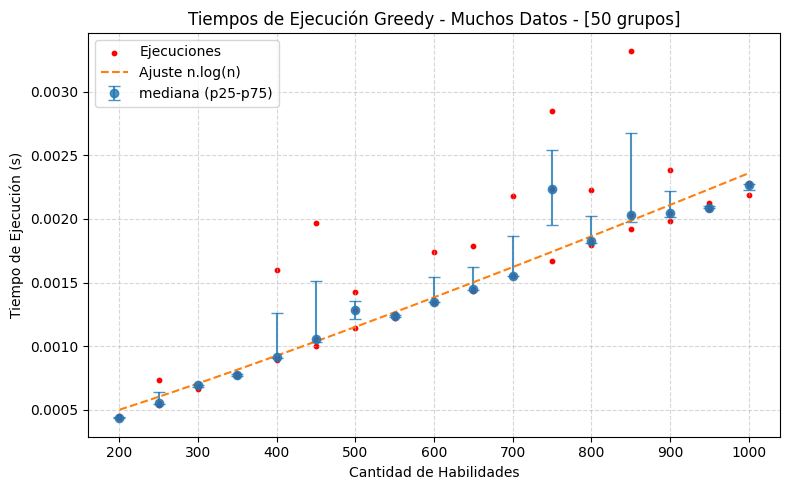

In [5]:

filas = []

total_iters = REPS * (MAX_TAM - MIN_TAM + 1)
iter_idx = 0

for i in range(REPS):
    for tam in range(MIN_TAM, MAX_TAM + 1, SALTO):
        iter_idx += 1
        habilidades = generar_habilidades(tam)

        inicio = time.perf_counter()
        greedy_pakku(CANT_GRUPOS, habilidades)
        dur = time.perf_counter() - inicio

        filas.append({"tam": tam, "iter": i, "tiempo": dur})

        # Indicador avance
        pct = iter_idx / total_iters * 100
        sys.stdout.write(f"\r— ejec {iter_idx}/{total_iters} ({pct:5.1f}%)")
        sys.stdout.flush()

print()

# Estadísticas por tamaño
df = pd.DataFrame(filas)
summary = df.groupby("tam")["tiempo"].agg(["median", "mean", "count",
                                           lambda x: np.percentile(x, 25),
                                           lambda x: np.percentile(x, 75)])
summary.columns = ["median", "mean", "count", "p25", "p75"]
# print(summary)

# Ajuste median con modelo n*log(n)
x = summary.index.values.astype(float)         # tamaños
y_med = summary["median"].values

# Evitar log(0)
x_safe = np.where(x > 0, x, 1)
x_logn = x_safe * np.log(x_safe)

# Ajuste lineal: y ≈ a * (n log n) + b
coeffs_nlogn = np.polyfit(x_logn, y_med, 1)
a_nlogn, b_nlogn = coeffs_nlogn[0], coeffs_nlogn[1]

def modelo_nlogn(xv):
    xv_safe = np.where(xv > 0, xv, 1)
    return a_nlogn * xv_safe * np.log(xv_safe) + b_nlogn


plt.figure(figsize=(8, 5))
plt.scatter(df["tam"], df["tiempo"], color='red',
            s=10, alpha=1, label="Ejecuciones")


plt.errorbar(x, y_med, yerr=[y_med - summary["p25"].values, summary["p75"].values - y_med],
             fmt='o', alpha=.8, capsize=4, label="mediana (p25-p75)")

xs = np.linspace(MIN_TAM, MAX_TAM, 200)
plt.plot(xs, modelo_nlogn(xs), linestyle='--',
         label=f"Ajuste n.log(n)")

plt.xlabel('Cantidad de Habilidades')
plt.ylabel('Tiempo de Ejecución (s)')
plt.title('Tiempos de Ejecución Greedy - Muchos Datos - [50 grupos]')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../informe/img/ajuste_greedy_pakku_muchos.png",
            dpi=300, bbox_inches='tight')
plt.show()